## Autoencoders

In [1]:
from keras.datasets import mnist
 
# load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

In [2]:
import numpy as np

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
 
# preparing the test samples as above
x_test = x_test.astype(np.float32) / 255.
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Simple autoencoder

In [3]:
from keras.layers import Input, Dense
from keras.models import Model
 
# this is the size of our encoded representations
# 32 floats -> compression of factor 24.5, assuming the input is 784 floats
encoding_dim = 32  
 
# this is our input placeholder
input_img = Input(shape=(784,))
 
# `encoded` is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
 
# `decoded` is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
 
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
 
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
 
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
 
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

### Training the model

In [5]:
# configure the model to use a binary crossentropy loss and the Adam optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')
 
# complete fit() call - as a starting point set epoch to 50, batch size to 256,
# shuffle data and use x_test as a validation set
# later you can experiment with those values
autoencoder.fit(
    x_train, 
    x_train,
    batch_size=256,
    epochs=50,
    shuffle=True,
    validation_data=(x_test, x_test)
)
 
# encode and decode some digits
# note that we take them from the "test" set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2766 - val_loss: 0.1886
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1686 - val_loss: 0.1518
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1434 - val_loss: 0.1341
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1287 - val_loss: 0.1216
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1182 - val_loss: 0.1128
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1107 - val_loss: 0.1066
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1023
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1018 - val_loss: 0.0990
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0991 - val_loss: 0.0968
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0973 - val_loss: 0.0953
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0961 - val_loss: 0.0943
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

### Visualization

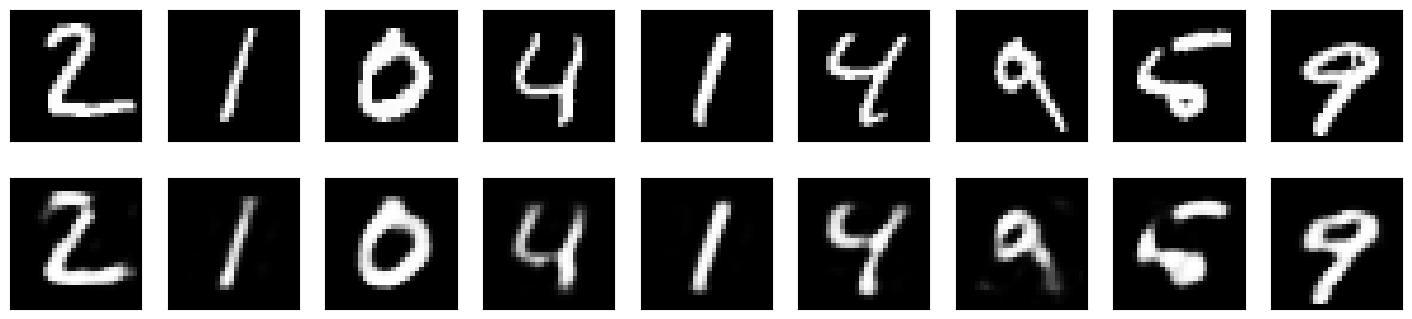

In [6]:
import matplotlib.pyplot as plt

# how many digits we will display
n = 10
plt.figure(figsize=(20, 4))

for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Convolutional autoencoder

In [7]:
# load the MNIST dataset and convert it to [0, 1] range like before
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
 
# prepare the test samples as above
x_test = x_test.astype(np.float32) / 255.
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

In [8]:
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K

# adapt this if using `channels_first` image data format
input_img = Input(shape=(28, 28, 1))  
 
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
 
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
 
autoencoder = Model(input_img, decoded)

# configure the model to use a binary crossentropy loss and the Adam optimizer
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

# complete fit() call - set epoch to 10, batch size to 128, shuffle data
# and use x_test as a validation set
# you can experiment with those values
# if training takes a lot of time, try to reduce the number of epochs (but monitor loss value)
autoencoder.fit(
    x_train,
    x_train,
    batch_size=128,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, x_test)
)
 
decoded_imgs = autoencoder.predict(x_test)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.2306 - val_loss: 0.1425
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1311 - val_loss: 0.1219
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1182 - val_loss: 0.1136
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1121 - val_loss: 0.1089
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1085 - val_loss: 0.1057
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1058 - val_loss: 0.1035
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1038 - val_loss: 0.1020
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1023 - val_loss: 0.1006
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1011 - val_loss: 0.0993
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1002 - val_loss: 0.0985
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


#### TODO: Visualise ten digits like in the first exercise

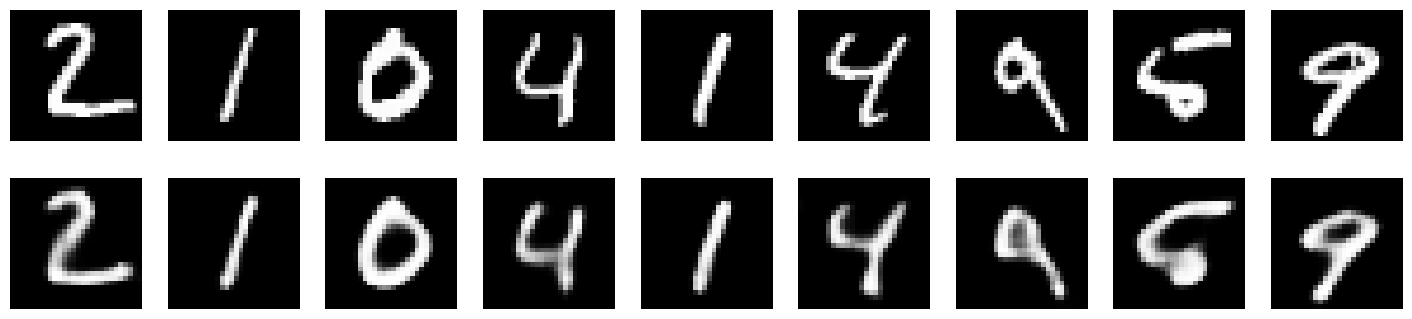

In [9]:
# how many digits we will display
n = 10
plt.figure(figsize=(20, 4))

for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.show()